# ДЗ 6: Ансамбль моделей машинного обучения для прогнозирования криптовалют

В этом ноутбуке мы создадим ансамбль моделей машинного обучения для прогнозирования движения цен криптовалют. Мы будем использовать:
- Различные классические модели (XGBoost, Random Forest, Gradient Boosting)
- Свёрточную нейронную сеть (CNN)
- Стекинг для объединения предсказаний моделей

## Импорт необходимых библиотек

In [1]:
from abc import ABC, abstractmethod
import os
import random
from typing import Dict, Tuple
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBClassifier
from assets.DataProvider import DataProvider
from assets.FeaturesGenerator import FeaturesGenerator
from assets.enums import DataPeriod, DataResolution

warnings.filterwarnings('ignore')

# Настройка окружения для воспроизводимости результатов
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
SEED = 777

## Определение вспомогательных классов

### CNN классификатор
Реализуем свёрточную нейронную сеть, совместимую с интерфейсом sklearn

In [2]:
class CNNClassifier:
    """CNN классификатор, совместимый с интерфейсом sklearn"""
    
    def __init__(self, input_shape: int = None, random_state: int = None,
                 epochs: int = 10, batch_size: int = 32,
                 conv1_filters: int = 32, conv2_filters: int = 64,
                 dense_units: int = 64, dropout_rate: float = 0.5):
        self.input_shape = input_shape
        self.random_state = random_state
        self.epochs = epochs
        self.batch_size = batch_size
        self.conv1_filters = conv1_filters
        self.conv2_filters = conv2_filters
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.classes_ = None
        self.model = None
        
    def get_params(self, deep: bool = True) -> dict:
        return {
            'input_shape': self.input_shape,
            'random_state': self.random_state,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'conv1_filters': self.conv1_filters,
            'conv2_filters': self.conv2_filters,
            'dense_units': self.dense_units,
            'dropout_rate': self.dropout_rate
        }
    
    def set_params(self, **params) -> 'CNNClassifier':
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f'Invalid parameter {key} for estimator {self.__class__.__name__}')
            setattr(self, key, value)
        return self
    
    def _build_model(self):
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            
        model = tf.keras.Sequential([
            tf.keras.layers.Reshape((self.input_shape, 1), input_shape=(self.input_shape,)),
            tf.keras.layers.Conv1D(self.conv1_filters, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(self.conv2_filters, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.dense_units, activation='relu'),
            tf.keras.layers.Dropout(self.dropout_rate),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    @property
    def _estimator_type(self):
        return 'classifier'
    
    def fit(self, X, y):
        """Обучение модели"""
        if self.input_shape is None:
            self.input_shape = X.shape[1]
            
        self.classes_ = np.unique(y)
        
        if self.model is None:
            self.model = self._build_model()
            
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        proba = self.model.predict(X, verbose=0)
        return np.hstack([1 - proba, proba])
    
    def predict(self, X):
        """Предсказание классов"""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

### Класс для оценки моделей
Создадим класс для вычисления метрик и визуализации результатов

In [3]:
class ModelEvaluator:
    """Класс для оценки и сравнения производительности моделей"""
    
    def evaluate_model(self, model, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """Расчет различных метрик для оценки модели"""
        y_pred = model.predict(X_test)
        return {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred)
        }
    
    def plot_model_comparison(self, model_metrics: Dict[str, Dict[str, float]]):
        """Построение графика сравнения производительности моделей"""
        metrics = list(next(iter(model_metrics.values())).keys())
        models = list(model_metrics.keys())
        n_metrics = len(metrics)
        n_models = len(models)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        width = 0.8 / n_models
        
        for i, model in enumerate(models):
            x = np.arange(n_metrics)
            values = [model_metrics[model][metric] for metric in metrics]
            ax.bar(x + i * width, values, width, label=model)
        
        ax.set_ylabel('Score')
        ax.set_title('Сравнение производительности моделей')
        ax.set_xticks(x + width * (len(models) - 1) / 2)
        ax.set_xticklabels(metrics)
        ax.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

## Подготовка данных

Загрузим данные криптовалют и подготовим признаки

In [4]:
def seed_everything(seed: int = 42) -> None:
    """Установка всех генераторов случайных чисел для воспроизводимости"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    print(f"Используется seed: {seed}")

# Устанавливаем seed
seed_everything(SEED)

# Инициализируем провайдер данных
data_provider = DataProvider(
    tickers=['BTC/USDT'],  # Используем пару BTC/USDT
    resolution=DataResolution.DAY_01,  # Дневные свечи
    period=DataPeriod.YEAR_01  # Данные за год
)

# Загружаем и обрабатываем данные
data_provider.data_load()

# Получаем обработанные данные
df = data_provider.data_processed['BTC/USDT']

# Создаем целевую переменную (направление движения цены)
y = (df['Returns'].shift(-1) > 0).astype(int)

# Генерируем признаки
features_generator = FeaturesGenerator()
features, feature_names = features_generator.prepare_features(df)

# Выравниваем данные по индексу
y = y[features.index]

# Конвертируем в numpy массивы
X = features.values
y = y.values

# Удаляем последнюю строку, так как для неё нет метки
X = X[:-1]
y = y[:-1]

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Дополнительное масштабирование для лучшей обработки выбросов
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_scaled)

# Выводим размерности данных
print(f"Размерность X: {X_scaled.shape}, размерность y: {y.shape}")

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=SEED)

Используется seed: 777
 Удалено 1 записей с высокой дисперсией для BTC/USDT
 Удалено 19 аномальных цен BTC/USDT
Размерность X: (2630, 62), размерность y: (2630,)


## Создание и обучение моделей

Создадим оптимизированные базовые модели и ансамбль

In [5]:
# Создаем оптимизированные базовые модели
base_models = {
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        bootstrap=True,
        random_state=SEED
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=SEED
    ),
    'CNN': CNNClassifier(
        input_shape=X_robust.shape[1],
        random_state=SEED,
        conv1_filters=128,
        conv2_filters=256,
        dense_units=128,
        dropout_rate=0.4
    )
}

# Создаем стекинг-ансамбль с оптимизированным мета-классификатором
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', base_models['XGBoost']),
        ('rf', base_models['Random Forest']),
        ('gb', base_models['Gradient Boosting']),
        ('cnn', base_models['CNN'])
    ],
    final_estimator=XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=SEED
    ),
    cv=5,
    n_jobs=-1
)

## Обучение и оценка моделей

Обучение базовых моделей...
Обучение XGBoost...
Производительность XGBoost: {'Accuracy': 0.4962025316455696, 'Precision': 0.5078534031413613, 'Recall': 0.4801980198019802, 'F1': 0.49363867684478374}
Обучение Random Forest...
Производительность Random Forest: {'Accuracy': 0.46835443037974683, 'Precision': 0.47674418604651164, 'Recall': 0.40594059405940597, 'F1': 0.4385026737967914}
Обучение Gradient Boosting...
Производительность Gradient Boosting: {'Accuracy': 0.5012658227848101, 'Precision': 0.5126903553299492, 'Recall': 0.5, 'F1': 0.506265664160401}
Обучение CNN...
Производительность CNN: {'Accuracy': 0.48860759493670886, 'Precision': 0.5, 'Recall': 0.4405940594059406, 'F1': 0.46842105263157896}

Обучение стекинг-ансамбля...
Производительность стекинг-ансамбля: {'Accuracy': 0.47848101265822784, 'Precision': 0.49130434782608695, 'Recall': 0.5594059405940595, 'F1': 0.5231481481481481}

Метрики производительности моделей:

XGBoost:
Accuracy: 0.4962
Precision: 0.5079
Recall: 0.4802
F1: 0

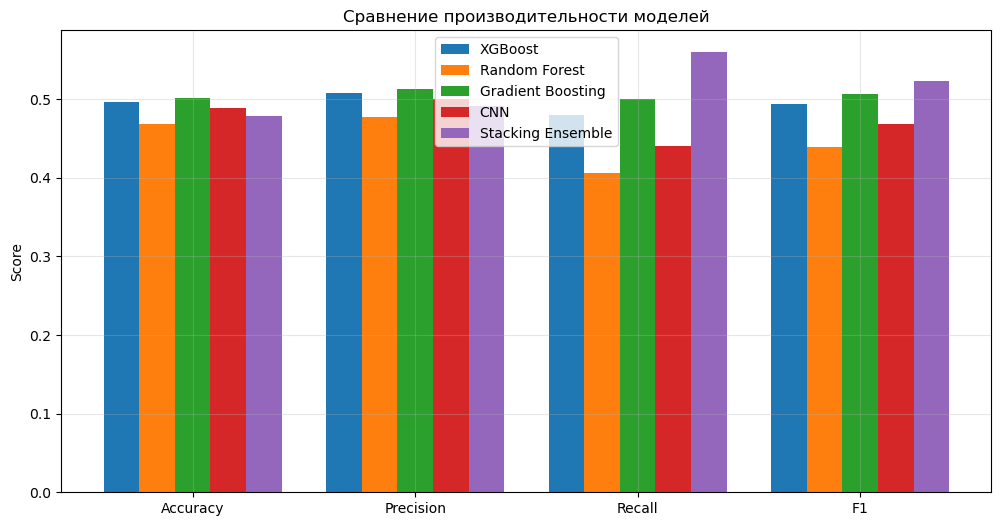

In [6]:
# Инициализируем словарь для метрик и оценщик
model_metrics = {}
evaluator = ModelEvaluator()

# Обучаем и оцениваем базовые модели
print("Обучение базовых моделей...")
for name, model in base_models.items():
    print(f"Обучение {name}...")
    model.fit(X_train, y_train)
    metrics = evaluator.evaluate_model(model, X_test, y_test)
    model_metrics[name] = metrics
    print(f"Производительность {name}: {metrics}")

# Обучаем и оцениваем стекинг-ансамбль
print("\nОбучение стекинг-ансамбля...")
stacking_clf.fit(X_train, y_train)
model_metrics['Stacking Ensemble'] = evaluator.evaluate_model(stacking_clf, X_test, y_test)
print(f"Производительность стекинг-ансамбля: {model_metrics['Stacking Ensemble']}")

# Выводим метрики
print("\nМетрики производительности моделей:")
for model_name, metrics in model_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

# Строим график сравнения
evaluator.plot_model_comparison(model_metrics)